## 1. Preliminary

In [9]:
import os
from IPython import get_ipython

ipython = get_ipython()

if not hasattr(ipython, "cd_executed"):
    ipython.run_line_magic("cd", "..")
    ipython.cd_executed = True
else:
    print(os.getcwd())

c:\Users\98165\Desktop\Social Network Mining


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import yaml
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_theme()
warnings.filterwarnings("ignore")

from utils import load_author_node, load_author_edge

## 2. Load the author node and edge

In [4]:
# Load config file and get the path of csv files
with open("./config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
base_dir = "data"

AUTHOR_NODE = base_dir / Path(config["data"]["author"]["node"])
AUTHOR_EDGE = base_dir / Path(config["data"]["author"]["edge"])

df_node = load_author_node(AUTHOR_NODE, False).iloc[2:]
df_edge = load_author_edge(AUTHOR_EDGE)

2024-12-17 21:01:57 - SocialNetwork - INFO - Load data\author\node.csv as dataframe, memory usage 839.68 MB
2024-12-17 21:01:57 - SocialNetwork - INFO - Function 'load_author_node' executed in 20.89 second(s)
2024-12-17 21:02:06 - SocialNetwork - INFO - Load data\author\edge.csv as dataframe, memory usage 1030.36 MB
2024-12-17 21:02:06 - SocialNetwork - INFO - Function 'load_author_edge' executed in 8.80 second(s)


In [5]:
df_node.info(verbose=True)
df_node.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904246 entries, 2 to 1904247
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              int64 
 1   name            string
 2   co_authors      object
 3   papers          object
 4   num_co_authors  Int32 
 5   num_papers      Int32 
dtypes: Int32(2), int64(1), object(2), string(1)
memory usage: 76.3+ MB


,id,name,co_authors,papers,num_co_authors,num_papers
2,3,(Max) Zong-Ming Cheng,"[197514, 229313, 319300, 341810, 411771, 54713...","[573695ab6e3b12023e4ca14d, 573695ab6e3b12023e4...",22,2
3,4,(Zhou) Bryan Bai,[1580950],"[573698766e3b12023e737002, 573696f96e3b12023e5...",1,2
4,5,A Lun,"[598680, 1813742, 1837042]",[573696f86e3b12023e5f3e82],3,1
5,6,A Min Tjoa,"[21424, 25842, 39524, 65557, 66578, 84768, 847...","[573695776e3b12023e49a7a2, 573696666e3b12023e5...",165,204
6,7,A'ang Subiyakto,"[22968, 1175140, 1620699]",[58437707ac44360f1082b3ed],3,1


##  3. Count NaN values

In [6]:
print(df_node.isna().sum())

id                    0
name                  0
co_authors        94703
papers                0
num_co_authors        0
num_papers            0
dtype: int64


## 4. Histplot the distribution of `list` columns

count    1904246.0
mean      8.805587
std      21.788735
min            0.0
25%            2.0
50%            4.0
75%            8.0
max         3851.0
Name: num_co_authors, dtype: Float64


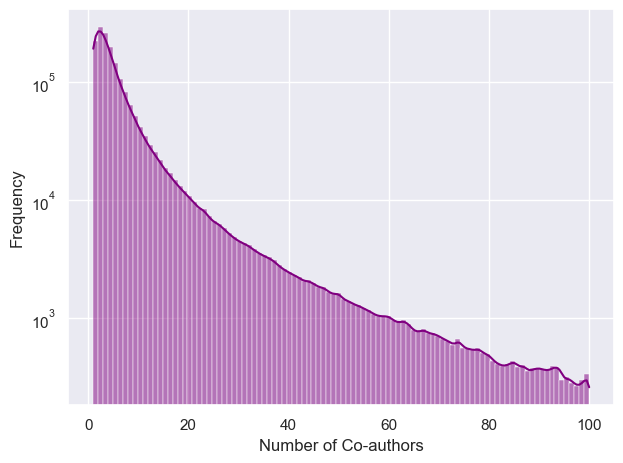

In [12]:
print(df_node["num_co_authors"].describe())
df_filtered_num_co_authors = df_node[
    (df_node["num_co_authors"] > 0) & (df_node["num_co_authors"] <= 100)
]

sns.histplot(
    df_filtered_num_co_authors["num_co_authors"], color="purple", kde=True, bins=100
)
plt.xlabel("Number of Co-authors")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()

count    1904246.0
mean      5.481235
std      17.929323
min            1.0
25%            1.0
50%            1.0
75%            4.0
max         2668.0
Name: num_papers, dtype: Float64


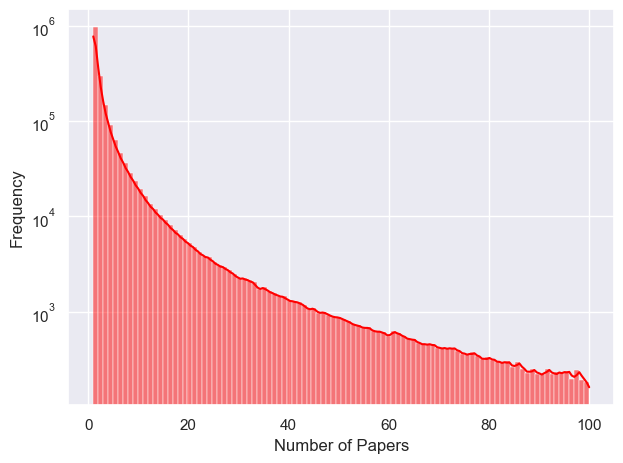

In [13]:
print(df_node["num_papers"].describe())
df_filtered_num_papers = df_node[
    (df_node["num_papers"] > 0) & (df_node["num_papers"] <= 100)
]

sns.histplot(df_filtered_num_papers["num_papers"], kde=True, color="red", bins=100)
plt.xlabel("Number of Papers")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()

## 5. Find abnormal rows

In [9]:
# NOTE: Due to the duplication of names, there exist some rows with number of papers/co_authors that are extremely large. We need to tackle it.
# Filter rows where num_papers > 100
rows_with_large_papers = df_node[df_node["num_papers"].apply(lambda x: x > 100)]

# Display the filtered rows
print(len(rows_with_large_papers))

10518


## 6. Visualize edges

In [10]:
df_edge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384576 entries, 0 to 8384575
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   src     string
 1   dst     string
 2   w       int16 
dtypes: int16(1), string(2)
memory usage: 143.9 MB


 98%|█████████▊| 49/50 [00:00<00:00, 76.14it/s]


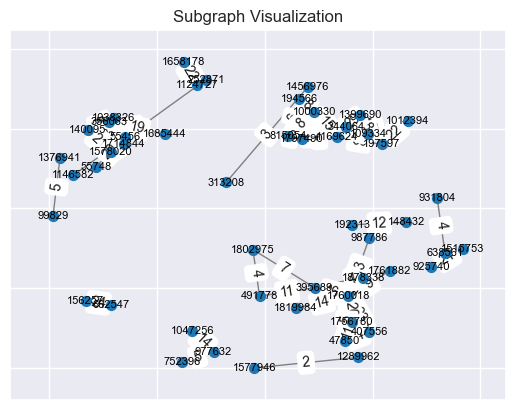

In [11]:
from tqdm import tqdm

# Create a subgraph from the desired edges
subgraph = nx.Graph()
count = 0
for _, row in tqdm(df_edge.iterrows(), total=50):
    subgraph.add_edge(row["src"], row["dst"], weight=row["w"])
    count += 1
    if count == 50:
        break


# Plot the subgraph
pos = nx.spring_layout(subgraph, seed=42, k=1)

nx.draw_networkx_nodes(subgraph, pos, node_size=50)
nx.draw_networkx_edges(subgraph, pos, edge_color="gray")
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")

# Add edge labels (weights)
edge_labels = nx.get_edge_attributes(subgraph, "weight")
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

plt.title("Subgraph Visualization")
plt.show()